In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2  

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read wheat and weather data

In [24]:
era = pd.read_csv("data/features/era_features_and_target_v2.csv")
nmme = pd.read_csv("nmme/data/features/bias_adjusted_nmme_features_v2.csv")
clik = pd.read_csv("clik-apcc/data/features/bias_adjusted_clik_features_v2.csv")
c3s = pd.read_csv("c3s/data/features/bias_adjusted_c3s_features_v2.csv")

nmme = nmme.loc[nmme["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
clik = clik.loc[clik["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
c3s = c3s.loc[c3s["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")

x_y_cv = pd.concat([era, nmme, clik, c3s], ignore_index=True).drop_duplicates()
x_y_cv = x_y_cv.loc[(x_y_cv["year"] <= 2016) & (x_y_cv["init_month"] >= 9), [c for c in x_y_cv.columns if "_8" not in c]].reset_index(drop=True)

### 3. Train model

#### 3.1 Expand features through basis functions

In [31]:
li = []
for model in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'NCEP', 'ERA', 'JMA', 'HMC', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:

    X = x_y_cv.loc[(x_y_cv["model"] == model), [c for c in x_y_cv.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]].reset_index(drop=True)
    y = x_y_cv.loc[(x_y_cv["model"] == model), ["model", "init_month", "year", "yield [kg/ha]", "yield anomaly [%]"]].reset_index(drop=True)
    X_columns = X.columns

    # scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]

    X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b", "tt_9_c", "tt_10_c", "tt_11_c", 
                                                                               "tt_9_d", "tt_10_d", "tt_11_d", "tt_9_e", "tt_10_e", "tt_11_e", "tt_9_f", "tt_10_f", "tt_11_f", "tt_9_g", "tt_10_g", "tt_11_g",])
    X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b",  "rr_9_c", "rr_10_c", "rr_11_c",  "rr_9_d", "rr_10_d", "rr_11_d",
                                                                              "rr_9_e", "rr_10_e", "rr_11_e", "rr_9_f", "rr_10_f", "rr_11_f", "rr_9_g", "rr_10_g", "rr_11_g"])
    X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b", "rt_9_c", "rt_10_c", "rt_11_c",
                                                                                            "rt_9_d", "rt_10_d", "rt_11_d", "rt_9_e", "rt_10_e", "rt_11_e", "rt_9_f", "rt_10_f", "rt_11_f", "rt_9_g", "rt_10_g", "rt_11_g"])

    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True))
    df = pd.concat([y, X], axis=1)
    li.append(df)

x_y_cv_expanded = pd.concat(li, ignore_index=True)[["model", "init_month", "year", "yield [kg/ha]", "yield anomaly [%]", "tt_11_a", "rr_9_e", "rr_11_g"]]

In [32]:
x_y_cv_expanded.head()

,model,init_month,year,yield [kg/ha],yield anomaly [%],tt_11_a,rr_9_e,rr_11_g
0,BOM,9,1993,2037.439151,-0.046171,1.521643,3.554137,0.089486
1,BOM,10,1993,2037.439151,-0.046171,0.582443,0.229933,0.183410
2,BOM,11,1993,2037.439151,-0.046171,1.287973,0.229933,0.208687
3,BOM,9,1994,2185.741998,0.018138,1.292940,1.500751,0.108086
4,BOM,10,1994,2185.741998,0.018138,0.617554,0.237376,3.980406


### 3.4 Train model

In [33]:
# K-Fold Cross Validation
def kfold_cross_validation(data, model="ECMWF", init=8, no_of_features=2):
    """Retrain, select features, and directly forecast yield on national level.
    
    params:
     - data: all features and yield on national level for all years
     - model: hindcast model to validate (default: ECMWF)
     - init: month of model initialization to validate (default:8)
     - no_of_features: the number of most correlated features with the target to be selected
     
    returns:
     - national_forecasts_by_year: dataframe with forecasted and observed national wheat yield for the selected model and month of initialization on cross validation
    """
    # Filter by model and init_month but also include observations that are used for model training
    if init == 12: model = "ERA"
    cv_dataset = (data.loc[((data["model"] == model) & (data["init_month"] == init))
                               | ((data["model"] == "ERA") & (data["init_month"] == 12))])
    # Dataframe where interim results are saved
    national_forecasts_by_year = (pd.DataFrame(data={"year":list(range(1993,2017)), "predicted":np.zeros(24)})
                                  .merge(cv_dataset.loc[(cv_dataset["model"] == "ERA"), 
                                                        ["year", "yield anomaly [%]"]], on="year", how="left"))
    # Features
    relevant_columns = [c for c in cv_dataset.columns if c not in ["model", "init_month", "year", "yield [kg/ha]", "yield_trend [kg/ha]", "yield anomaly [%]"]]
    
    for season in list(range(1993,2017)):
        X_train = cv_dataset.loc[((cv_dataset["model"] == "ERA") & (cv_dataset["year"] != season)) 
                                 | ((cv_dataset["model"] == model) & (cv_dataset["year"] != season) & (cv_dataset["init_month"] == init)), relevant_columns].reset_index(drop=True)
        y_train = cv_dataset.loc[((cv_dataset["model"] == "ERA") & (cv_dataset["year"] != season)) 
                                 | ((cv_dataset["model"] == model) & (cv_dataset["year"] != season) & (cv_dataset["init_month"] == init)), "yield anomaly [%]"].reset_index(drop=True)
        
        #print(season)
        #print(X_train)    
        pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=no_of_features)),
                             ('estimator', Ridge())])
        
        reg = pipeline.fit(X_train, y_train)  
        
        coefficients = reg["estimator"].coef_
        bias = reg["estimator"].intercept_
        features = reg["selector"].get_feature_names_out(relevant_columns)
        #print(features)
        X_val = cv_dataset.loc[(cv_dataset["model"] == model)
                               & (cv_dataset["year"] == season), relevant_columns].reset_index(drop=True)
        
        y_predicted = reg.predict(X_val)[0]
            
        # each forecast is weighted by the group's relative contribution to national harvested area
        national_forecasts_by_year.loc[national_forecasts_by_year["year"] == season, "predicted"] = y_predicted
    
    return national_forecasts_by_year

In [34]:
x_y_cv_expanded["model"].unique()

array(['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'NCEP', 'ERA', 'JMA',
       'HMC', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA'],
      dtype=object)

In [7]:
models = ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'NCEP', 'ERA', 'JMA',
       'HMC', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']
results = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=2)
        res = res.loc[res["year"].isin([2008, 2002, 2013, 2010, 2011, 1997])].reset_index(drop=True)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results.transpose()

,BOM,CMCC,CWB,DWD,ECCC,ECMWF,NCEP,ERA,JMA,HMC,KMA,METFR,PNU,UKMO,CCSM4,GFDL,NASA
9,-0.18,-0.09,-0.18,-0.35,-1.99,-0.58,-0.43,0.63,-0.23,-0.33,-0.62,-0.25,-0.21,-0.40,0.05,-0.21,0.11
10,0.38,0.39,0.49,0.37,0.50,0.33,0.34,0.63,0.39,0.49,0.41,0.17,0.13,0.49,0.11,0.47,0.49
11,0.41,0.42,0.46,0.38,0.40,0.38,0.34,0.63,0.41,0.42,0.48,0.46,0.38,0.47,0.53,0.47,0.42


In [35]:
models = ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'NCEP', 'ERA', 'JMA',
       'HMC', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']
results = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=3)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results.transpose()

,BOM,CMCC,CWB,DWD,ECCC,ECMWF,NCEP,ERA,JMA,HMC,KMA,METFR,PNU,UKMO,CCSM4,GFDL,NASA
9,-0.37,-0.41,-0.38,-0.80,-0.61,-0.65,-0.35,0.43,-0.09,-0.37,-0.75,-0.58,-0.41,-0.27,-0.34,-0.76,-0.23
10,0.29,0.24,0.24,0.36,0.27,0.10,0.19,0.43,0.29,0.30,0.21,0.18,0.29,0.25,0.24,0.39,0.29
11,0.30,0.30,0.28,0.26,0.14,0.21,0.28,0.43,0.30,-0.01,0.16,0.18,0.13,0.28,0.22,0.18,0.39


#### 3.5 MME

In [12]:
df_lean = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 10) & (x_y_cv_expanded["model"] != "ERA"), ['model', 'year', 'init_month', 'rr_11_b', 'rt_9_a']].reset_index(drop=True)
df_lean_era = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 12) & (x_y_cv_expanded["model"] == "ERA"), ['model', 'year', 'init_month', 'rr_11_b', 'rt_9_a']].reset_index(drop=True)

model_to_error = {}

for model in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', "HMC", 'NCEP', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
    bias = np.array(df_lean.loc[df_lean["model"] == model, ['rr_11_b', 'rt_9_a']]) -  np.array(df_lean_era.loc[df_lean_era["model"] == "ERA", ['rr_11_b', 'rt_9_a']])
    model_to_error[model] = bias

for model1 in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', "HMC", 'NCEP', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
    for model2 in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', "HMC", 'NCEP', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
        r = pearsonr(np.array(model_to_error[model1]).reshape(-1,1).flatten(), 
                     np.array(model_to_error[model2]).reshape(-1,1).flatten())[0]
        if r < 0.3:
            print("model1 {} with model2 {} has r of {}".format(model1, model2, np.round(r,2)))

model1 DWD with model2 NASA has r of 0.1
model1 ECCC with model2 PNU has r of 0.14
model1 ECCC with model2 NASA has r of 0.17
model1 JMA with model2 NASA has r of 0.23
model1 KMA with model2 HMC has r of 0.26
model1 KMA with model2 NASA has r of 0.28
model1 METFR with model2 NASA has r of 0.1
model1 HMC with model2 KMA has r of 0.26
model1 HMC with model2 NCEP has r of 0.26
model1 NCEP with model2 HMC has r of 0.26
model1 NCEP with model2 PNU has r of 0.05
model1 NCEP with model2 NASA has r of 0.2
model1 PNU with model2 ECCC has r of 0.14
model1 PNU with model2 NCEP has r of 0.05
model1 UKMO with model2 NASA has r of 0.28
model1 NASA with model2 DWD has r of 0.1
model1 NASA with model2 ECCC has r of 0.17
model1 NASA with model2 JMA has r of 0.23
model1 NASA with model2 KMA has r of 0.28
model1 NASA with model2 METFR has r of 0.1
model1 NASA with model2 NCEP has r of 0.2
model1 NASA with model2 UKMO has r of 0.28


In [13]:
mme1 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["NASA", "DWD", "KMA"])].assign(model="MME_BEST_OCT").groupby(["model", "year", "init_month"]).mean().reset_index()
mme2 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(['DWD', 'CCSM4'])].assign(model="MME_BEST_NOV").groupby(["model", "year", "init_month"]).mean().reset_index()
mme3 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["NASA", "DWD"])].assign(model="MME_UC").groupby(["model", "year", "init_month"]).mean().reset_index()
mme4 = x_y_cv_expanded.loc[x_y_cv_expanded["model"] != "ERA"].assign(model="MME_ALL").groupby(["model", "year", "init_month"]).mean().reset_index()

x_y_cv_mme = pd.concat([mme1, mme2, mme3, mme4, x_y_cv_expanded], ignore_index=True)

In [14]:
from itertools import combinations

In [29]:
model_combinations = list(combinations(['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', "HMC", 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA'], 1))
print(len(model_combinations))
results = []
for i in range(0, len(model_combinations)):
    combi = list(model_combinations[i])
    mme = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(combi)].assign(model="MME_{}".format(combi[0])).groupby(["model", "year", "init_month"]).mean().reset_index()
    x_y_cv_mme = pd.concat([mme, x_y_cv_expanded], ignore_index=True)
    res = kfold_cross_validation(x_y_cv_mme, model="MME_{}".format(combi[0]), init=10, no_of_features=2)
    metric = r2(res["yield anomaly [%]"], res["predicted"])
    results.append(metric)
    if metric > 0.45:
        print("r2 is {} for MME_{}".format(np.round(metric, 2), combi[0]))
    

15


In [25]:
results_two_models = results

In [20]:
results_four_models = results

In [30]:
np.array(results).mean()

0.2955969470195704

In [26]:
np.array(results_four_models).mean()

0.30339488587033425

In [27]:
np.array(results_two_models).mean()

0.30379612936622413

In [82]:
x_y_cv_mme["model"].unique()

array(['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC', 'MME_ALL', 'BOM', 'CMCC',
       'CWB', 'DWD', 'ECCC', 'ECMWF', 'NCEP', 'ERA', 'JMA', 'HMC', 'KMA',
       'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA'], dtype=object)

In [84]:
models = ['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC', 'MME_ALL', 'ERA']
results = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_mme, model=model, init=im, no_of_features=2)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results

,9,10,11
MME_BEST_OCT,-0.30,0.30,0.44
MME_BEST_NOV,-0.34,0.25,0.26
MME_UC,-0.34,0.31,0.42
MME_ALL,-0.28,0.30,0.38
ERA,0.53,0.53,0.53


In [71]:
models = ['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC', 'MME_ALL', 'ERA']
results = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=2)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results

,9,10,11
MME_BEST_OCT,-0.29,0.45,0.42
MME_BEST_NOV,-0.02,0.34,0.30
MME_UC,-0.49,0.36,0.42
MME_ALL,-0.30,0.43,0.28
ERA,0.53,0.53,0.53


In [60]:
models = ['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC', 'MME_ALL', 'ERA']
results = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=2)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results

,9,10,11
MME_BEST_OCT,-0.26,0.32,0.41
MME_BEST_NOV,-0.29,0.33,0.44
MME_UC,-0.34,0.31,0.42
MME_ALL,-0.28,0.30,0.38
ERA,0.53,0.53,0.53


In [33]:
def perform_simulations_and_compute_metrics(df):
    rmse_scores = pd.DataFrame(0, index=models, columns=[9, 10, 11])
    r2_scores = pd.DataFrame(0, index=models, columns=[9, 10, 11])
    #mape_scores = pd.DataFrame(0, index=models, columns=[9, 10, 11])
    simulations = []
    for month in [9, 10, 11]:
        for model in ['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC', 'MME_ALL', 'BOM', 'CMCC',
       'CWB', 'DWD', 'ECCC', 'ECMWF', 'ERA', 'JMA', 'HMC', 'KMA', 'METFR',
       'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
            res = kfold_cross_validation(df, model=model, init=month, no_of_features=2)
            res = res.assign(model=model, init_month=month)
            simulations.append(res)
            # rmse
            rmse_score = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
            rmse_scores.loc[model, month] = np.round(rmse_score, 2)
            # coefficient of determination
            r2_score = r2(res["yield anomaly [%]"], res["predicted"])
            r2_scores.loc[model, month] = np.round(r2_score, 2)
            # mean absolute percentage error
            #mape_score = 100 * mape(res["yield anomaly [%]"], res["predicted"])
            #mape_scores.loc[model, month] = np.round(mape_score, 2)
    
    simulations = pd.concat(simulations, ignore_index=False, axis=0)    
    return (simulations, rmse_scores, r2_scores)

In [35]:
simulations, rmse_scores, r2_scores = perform_simulations_and_compute_metrics(x_y_cv_expanded)

In [36]:
simulations

,year,predicted,yield anomaly [%],model,init_month
0,1993,0.015167,-0.047265,MME_BEST_OCT,9
1,1994,-0.047283,0.019682,MME_BEST_OCT,9
2,1995,-0.031930,-0.100301,MME_BEST_OCT,9
3,1996,-0.058953,0.043680,MME_BEST_OCT,9
4,1997,0.070754,0.173768,MME_BEST_OCT,9
...,...,...,...,...,...
19,2012,0.023078,-0.077833,NASA,11
20,2013,-0.017459,-0.158174,NASA,11
21,2014,-0.025475,-0.094534,NASA,11
22,2015,0.032760,-0.036487,NASA,11


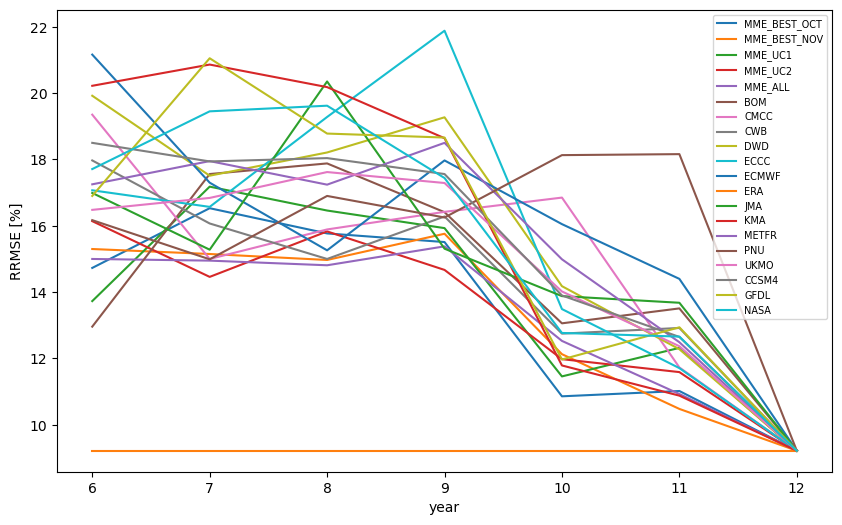

In [23]:
plt.rcParams["figure.figsize"] = (10,6)
results.transpose().plot()
plt.ylabel("RRMSE [%]")
plt.xlabel("year")
plt.legend(fontsize=7)
#plt.savefig("rrmse.svg")
plt.show()